In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
print("Lets check if TensorFlow can find a GPU...")
gpu_tensorflow = tf.test.gpu_device_name()
if gpu_tensorflow:
  print("Success! Tensorflow found gpu!")
  print("GPU Name:",gpu_tensorflow)
else:
  print("Oops! GPU not found!")

print("Finished checking for GPU...")

Lets check if TensorFlow can find a GPU...
Success! Tensorflow found gpu!
GPU Name: /device:GPU:0
Finished checking for GPU...


In [34]:
try:
    df = pd.read_csv(
        "/content/Suicide_Detection.csv",
        encoding="utf-8",
        quotechar='"',       # Recognize quoted multiline text properly
        quoting=0,           # csv.QUOTE_MINIMAL - quote fields only if they contain special characters
        escapechar="\\",     # Handle any escaped characters (like \")
        engine="python",     # More flexible with quoted multiline strings
        on_bad_lines='skip'  # Skip problematic rows instead of raising an error
    )

    print("File loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except pd.errors.ParserError as e:
    print(f"An error occurred while reading the CSV: {e}")

File loaded successfully!
Dataset shape: (232063, 3)


In [35]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [36]:
# Mapping the text to words
mapping = {"suicide": 1,"non-suicide":0}
df["class"] = df["class"].map(mapping)

In [37]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1.0
1,3,Am I weird I don't get affected by compliments...,0.0
2,4,Finally 2020 is almost over... So I can never ...,0.0
3,8,i need helpjust help me im crying so hard,1.0
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232063 entries, 0 to 232062
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  232063 non-null  object 
 1   text        232056 non-null  object 
 2   class       232046 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.3+ MB


In [39]:
df = df[pd.to_numeric(df['Unnamed: 0'], errors='coerce').notnull()]

In [40]:
df['Unnamed: 0'] = pd.to_numeric(df['Unnamed: 0'])

In [41]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
class,3


In [42]:
df.dropna(inplace= True)

In [43]:
print(f"Shape after dropping null values: {df.shape}")

Shape after dropping null values: (232045, 3)


In [44]:
df.describe()

,Unnamed: 0,class
count,232045.000000,232045.000000
mean,174151.671852,0.500019
std,100500.877429,0.500001
min,2.000000,0.000000
25%,87048.000000,0.000000
50%,174357.000000,1.000000
75%,261285.000000,1.000000
max,348110.000000,1.000000


In [45]:
# Preprocess the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000,oov_token="<OOV>")
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])
padded_sequences = pad_sequences(sequences,maxlen=200)

In [46]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(padded_sequences,df["class"],test_size = 0.2,stratify=df["class"],random_state = 42)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D, MaxPooling1D,Bidirectional,LSTM,Dense,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [48]:
model = Sequential()
model.add(Embedding(20000,64,input_length = 200))
model.add(Conv1D(128,5,activation="relu",kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32,dropout=0.4,recurrent_dropout=0.1,activation="tanh",recurrent_activation="sigmoid")))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid",kernel_regularizer=l2(0.01)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [51]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1)

In [52]:
history = model.fit(x_train,y_train, batch_size = 128, epochs = 10, validation_data=(x_test,y_test),callbacks=[early_stop,reduce_lr],verbose=1)

Epoch 1/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 501s 335ms/step - accuracy: 0.8795 - loss: 0.3278 - val_accuracy: 0.9394 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 2/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 466s 314ms/step - accuracy: 0.9449 - loss: 0.1743 - val_accuracy: 0.9421 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 3/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 506s 317ms/step - accuracy: 0.9512 - loss: 0.1576 - val_accuracy: 0.9431 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 4/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9568 - loss: 0.1438
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 451s 311ms/step - accuracy: 0.9568 - loss: 0.1438 - val_accuracy: 0.9432 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 5/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9650 - loss: 0.1238
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 501s 311ms/ste

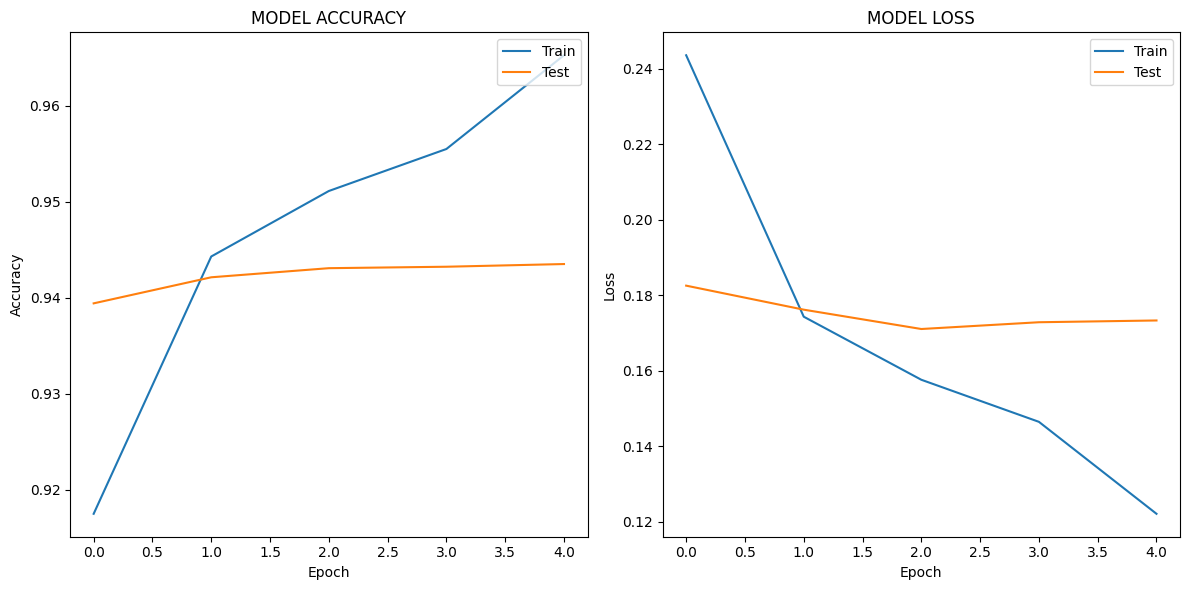

In [53]:
# Visualizing training and validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MODEL ACCURACY")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Test"],loc = "upper right")

# Visualizing training and validation loss values
plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("MODEL LOSS")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train","Test"],loc="upper right")

plt.tight_layout()
plt.show()

In [54]:
# Evaluating the model
loss,accuracy = model.evaluate(x_test,y_test)
print("Test Accuracy: ",accuracy*100)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.9422 - loss: 0.1718
Test Accuracy:  94.3092942237854


In [55]:
y_pred_prob = model.predict(x_test) # sigmoid probabilities as output

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step


In [56]:
y_pred = (y_pred_prob>0.5).astype("int32")

In [57]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred)
print(f"Confusion Matrix: {cm}")
print(classification_report(y_test,y_pred))

Confusion Matrix: [[21924  1280]
 [ 1361 21844]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     23204
         1.0       0.94      0.94      0.94     23205

    accuracy                           0.94     46409
   macro avg       0.94      0.94      0.94     46409
weighted avg       0.94      0.94      0.94     46409



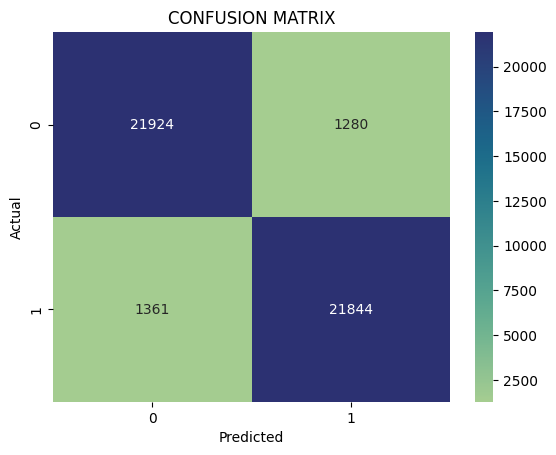

In [58]:
# Confusion matrix
import seaborn as sns

sns.heatmap(cm,annot = True,cmap="crest",fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()